In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
%load_ext sql

In [3]:
%sql sqlite:///onepam.db

'Connected: @onepam.db'

In [4]:
contributions_q = '''
SELECT
    ac.author_name,
    ac.n_commits,
    ac.n_lines_added,
    ac.n_lines_deleted,
    ac.n_lines_changed
FROM
    authors_contributions ac
ORDER BY
    ac.n_commits DESC;
'''
contributions = %sql $contributions_q
contributions = contributions.DataFrame()

 * sqlite:///onepam.db
Done.


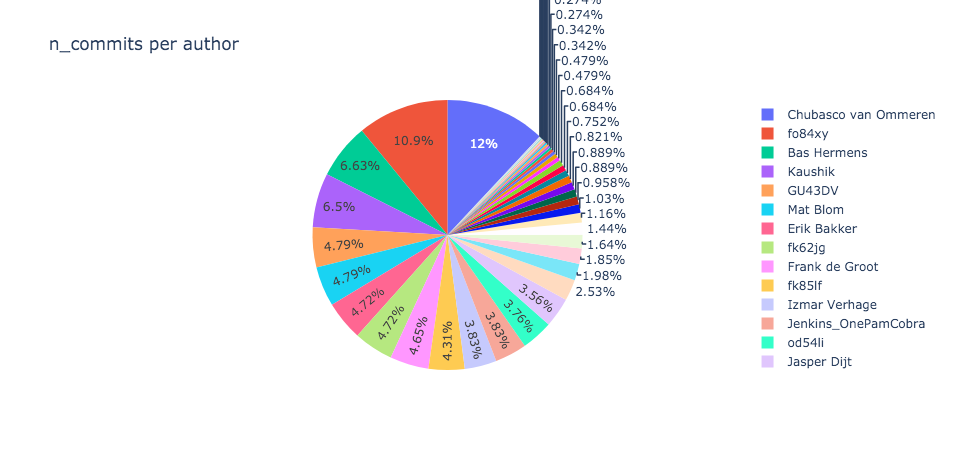

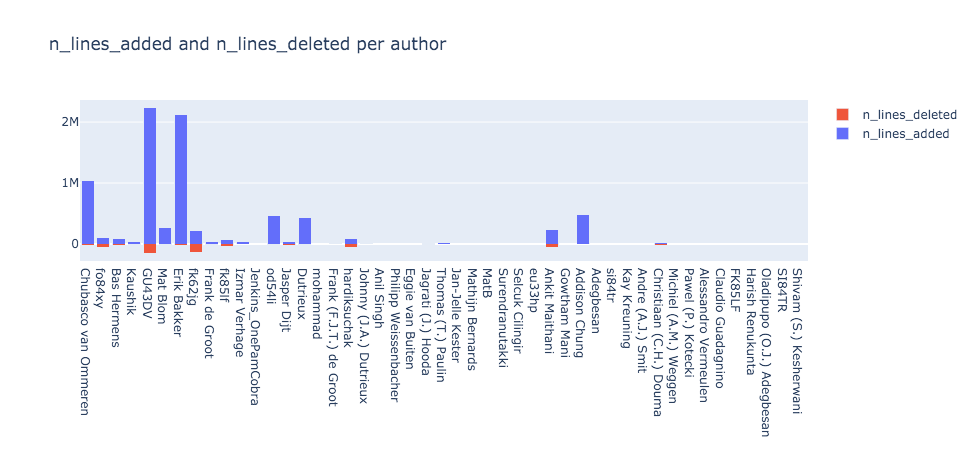

In [5]:
fig = px.pie(contributions, title='n_commits per author', values='n_commits', names='author_name')
fig.show()

fig = go.Figure(data=[
    go.Bar(name='n_lines_added', x=contributions.author_name, y=contributions.n_lines_added, base=0),
    go.Bar(name='n_lines_deleted', x=contributions.author_name, y=contributions.n_lines_deleted, base=list(map(lambda x: -x, contributions.n_lines_deleted))),
])
fig.update_layout(title='n_lines_added and n_lines_deleted per author', barmode='stack')
fig.show()

In [6]:
changes_over_time_q = '''
SELECT
    cc.*,
    AVG(cc.n_files) OVER (ORDER BY cc.commit_date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING) AS avg_files,
    c.message AS commit_message
FROM
    commits_changes cc JOIN commits c ON cc.commit_hash = c.hash;
'''

changes_over_time = %sql $changes_over_time_q
changes_over_time = changes_over_time.DataFrame().astype({'commit_date': 'datetime64[ns]'})

 * sqlite:///onepam.db
Done.


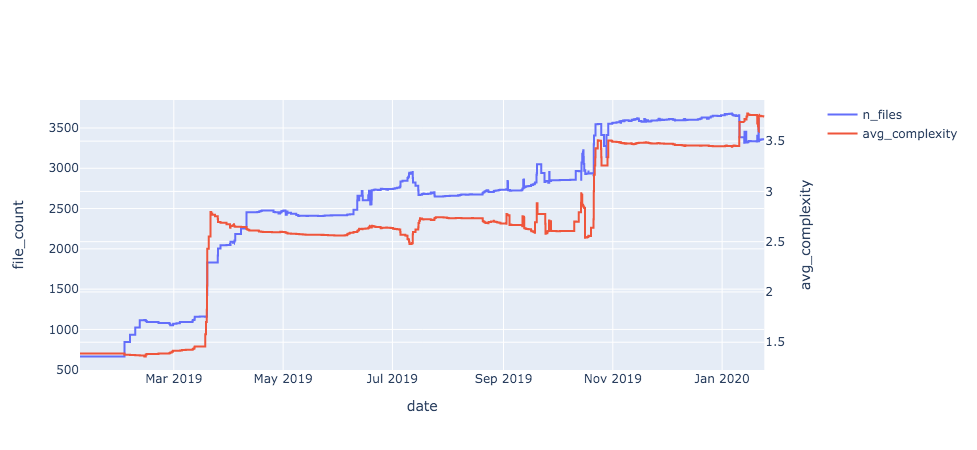

In [7]:
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.update_xaxes(title_text='date')

fig.add_trace(go.Scatter(x=changes_over_time.commit_date, y=changes_over_time.avg_files, name='n_files', line_shape='hvh', hovertext=changes_over_time.commit_message))
fig.update_yaxes(title_text='file_count')

fig.add_trace(go.Scatter(x=changes_over_time.commit_date, y=changes_over_time.avg_complexity, name='avg_complexity', line_shape='hvh', hovertext=changes_over_time.commit_message), secondary_y=True)
fig.update_yaxes(title_text='avg_complexity', secondary_y=True)

fig.show()

In [8]:
coupling_q = 'SELECT * FROM files_coupling fc;'
coupling = %sql $coupling_q
coupling = coupling.DataFrame()

display(coupling)

# TODO: Chord diagram, ideally grouped by package

 * sqlite:///onepam.db
Done.


file1  \
0                                TpaOnePamMandates/pom.xml   
1                                                  pom.xml   
2           TpaOnePamMandates/TpaOnePamMandatesApi/pom.xml   
3        TpaOnePamMandates/TpaOnePamMandatesDeployConfi...   
4           TpaOnePamMandates/TpaOnePamMandatesApi/pom.xml   
...                                                    ...   
5229265  validations/src/test/java/com/ing/tpa/onepam/V...   
5229266  validations/src/test/java/com/ing/tpa/onepam/V...   
5229267  validations/src/test/java/com/ing/tpa/onepam/V...   
5229268  validations/src/test/java/com/ing/tpa/onepam/V...   
5229269  validations/src/test/java/com/ing/tpa/onepam/V...   

                                                     file2  abs_coupling  
0                                                  pom.xml            57  
1                                TpaOnePamMandates/pom.xml            57  
2        TpaOnePamMandates/TpaOnePamMandatesDeployConfi...            55  
3           TpaOnePamMandates/TpaOnePamMandatesApi/pom.xml            55  
4                                TpaOnePamMandates/pom.xml            54  
...                                                    ...           ...  
5229265  storage/storage-sqlserver/src/main/java/com/in...             1  
5229266  storage/storage-sqlserver/src/test/java/com/in...             1  
5229267  validations/src/main/java/com/ing/tpa/onepam/I...             1  
5229268  validations/src/main/java/com/ing/tpa/onepam/O...             1  
5229269  validations/src/main/java/com/ing/tpa/onepam/V...             1  

[5229270 rows x 3 columns]

In [9]:
changes_x_size_complexity_q = '''
SELECT
    f."path" AS file_path,
    COUNT(s.file_path) AS n_changes,
    AVG(s.code_lines) AS avg_code_lines,
    AVG(s.complexity) AS avg_complexity
FROM
    files f,
    snapshots s
WHERE
    s.file_path = f."path" AND
    s.changed = TRUE AND
    f.language in ('scala', 'java')
GROUP BY
    f.file_name;
'''

changes_x_size_complexity = %sql $changes_x_size_complexity_q
changes_x_size_complexity = changes_x_size_complexity.DataFrame()

 * sqlite:///onepam.db
Done.


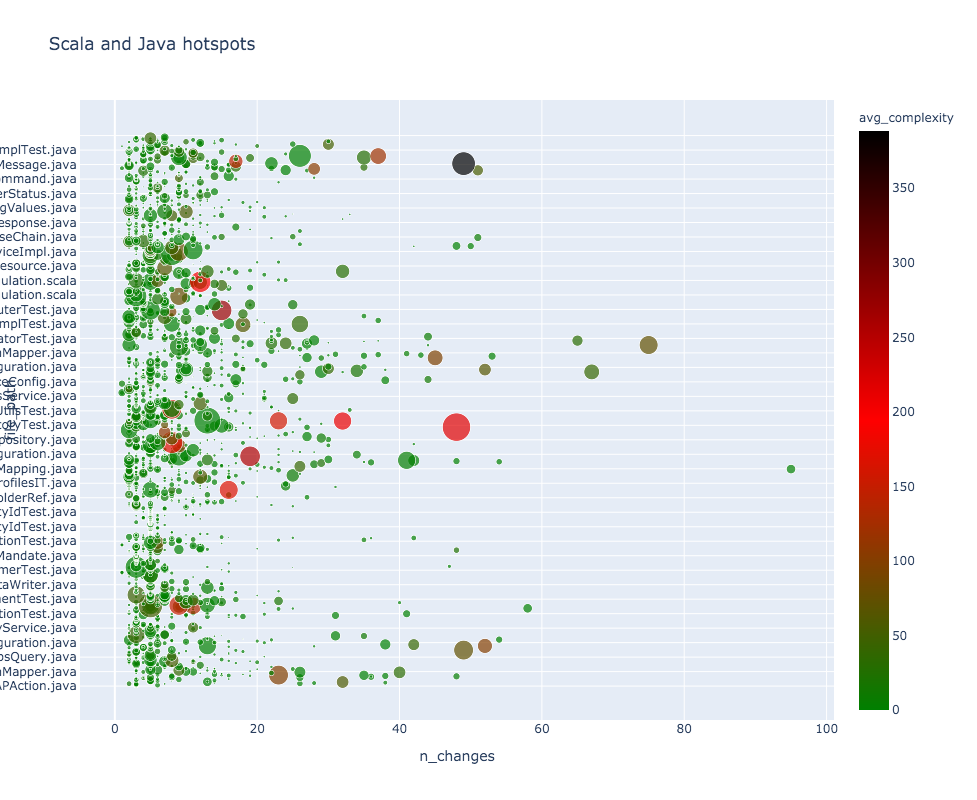

In [10]:
fig = px.scatter(
    changes_x_size_complexity,
    x='n_changes',
    y='file_path',
    size='avg_code_lines',
    color='avg_complexity',
    title='Scala and Java hotspots',
    hover_data=['file_path'],
    color_continuous_scale=["green", "red", "black"],
    height=800,
)
fig.update_layout(
    yaxis = dict(
        tickmode='array',
        tickson='boundaries',
        showline=True,
    )
)
fig.show()

# TODO: Circle Packing Chart by package